In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


In [2]:
from importlib import reload
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
from tqdm.auto import tqdm, trange
import mmcv
import data
import bbox
from utils import imshownp
import utils
import meva
from meva.lib.meva_model import MEVA
from meva.utils import kp_utils
from meva.utils import image_utils
from meva.utils.video_config import update_cfg
from torch.utils.data import DataLoader
import joblib
import scipy.ndimage

/home/tormod/Documents/APEC/meva/utils/transformations.py:1927: UserWarning: No module named 'meva.utils._transformations'
  warnings.warn(str(err))


In [3]:
from importlib import reload
reload(data)

<module 'data' from '/home/tormod/Documents/APEC/data.py'>

In [13]:
c = data.ClimbingDataset('all', seq_len=90)#, preload_all=True)

In [132]:
pretrained_file = f"results/meva/train_meva_2/model_best.pth.tar"
config_file = f"meva/cfg/train_meva_2.yml"
cfg = update_cfg(config_file)

In [133]:
batch_size = 6
model = MEVA(
    n_layers=cfg.MODEL.TGRU.NUM_LAYERS,
    batch_size=batch_size,
    seqlen=cfg.DATASET.SEQLEN,
    hidden_size=cfg.MODEL.TGRU.HIDDEN_SIZE,
    add_linear=cfg.MODEL.TGRU.ADD_LINEAR,
    bidirectional=cfg.MODEL.TGRU.BIDIRECTIONAL,
    use_residual=cfg.MODEL.TGRU.RESIDUAL,
    cfg=cfg.VAE_CFG,
)
ckpt = torch.load(pretrained_file, map_location='cpu')
# print(f'Performance of pretrained model on 3DPW: {ckpt["performance"]}')
ckpt = ckpt['gen_state_dict']
model.load_state_dict(ckpt)
model.eval()

loading VAErecV2 model from checkpoint: results/meva/vae_rec_2/models/model_1000.p


MEVA(
  (vae_model): VAErecV2(
    (e_rnn): RNN(
      (rnn_f): GRUCell(144, 256)
      (rnn_b): GRUCell(144, 256)
    )
    (e_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (e_mu): Linear(in_features=512, out_features=512, bias=True)
    (e_logvar): Linear(in_features=512, out_features=512, bias=True)
    (d_rnn): RNN(
      (rnn_f): GRUCell(656, 512)
    )
    (d_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (d_out): Linear(in_features=512, out_features=144, bias=True)
    (init_pose_mlp): MLP(
      (affine_layers): ModuleList(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): Linear(in_features=1024, out_features=512, bias=True)
      )
    )
    (init_p

In [134]:
batch_size=6
dataloader = DataLoader(c, batch_size=batch_size, num_workers=0, shuffle = False)

In [135]:
import time
output = {}
pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d, norm_joints2d = [], [], [], [], [], []
for seqs in iter(dataloader):
    with torch.no_grad():
        start = time.time()
        feats = seqs['features']
        output = model(feats)[-1]
        finish = time.time()
        pred_cam.append(output['theta'][:, :, :3])
        pred_verts.append(output['verts'])
        pred_pose.append(output['theta'][:, :, 3:75])
        pred_betas.append(output['theta'][:, :, 75:])
        pred_joints3d.append(output['kp_3d'])
        norm_joints2d.append(output['kp_2d'])
    break
pred_cam = torch.cat(pred_cam, dim=0)
pred_verts = torch.cat(pred_verts, dim=0)
pred_pose = torch.cat(pred_pose, dim=0)
pred_betas = torch.cat(pred_betas, dim=0)
pred_joints3d = torch.cat(pred_joints3d, dim=0)
norm_joints2d = torch.cat(norm_joints2d, dim=0)

pred_cam = pred_cam.cpu().numpy()
pred_verts = pred_verts.cpu().numpy()
pred_pose = pred_pose.cpu().numpy()
pred_betas = pred_betas.cpu().numpy()
pred_joints3d = pred_joints3d.cpu().numpy()
norm_joints2d = norm_joints2d.cpu().numpy()
output_dict = {'pred_cam': pred_cam,
               'verts': pred_verts,
               'pose': pred_pose,
               'betas': pred_betas,
               'joints3d': pred_joints3d,
               'joints2d': norm_joints2d}

In [ ]:
res = output_dict

In [136]:
(finish-start)*len(c)/batch_size

131.89726448059082

In [8]:
res_folder = '/home/tormod/ucph-erda-home/pretrained_meva_results'
vid_idx = 0
vid_name = data.stripped_names[vid_idx]
res = joblib.load(f'{res_folder}/{vid_name}.pkl')

In [17]:
res.keys()

dict_keys(['pred_cam', 'verts', 'pose', 'betas', 'joints3d', 'joints2d'])

In [18]:
seqidx = 2
frameid = 50
seqinfo = c.get(seqidx)

/home/tormod/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


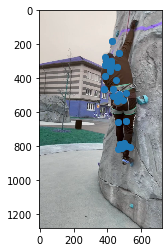

In [29]:
inv_trans = seqinfo['inv_trans'][frameid].copy()
kp_2d = res['joints2d'][seqidx, frameid].copy()
#kp_2d *= 1.2
kp_2d = image_utils.normalize_2d_kp(kp_2d, inv=True)
kp_2d = image_utils.trans_points2d(kp_2d, inv_trans)
plt.imshow(seqinfo['raw_imgs'][frameid])
plt.scatter(kp_2d[:,0], kp_2d[:,1])
plt.show();

[0.6886164  0.01665802 0.26140934]


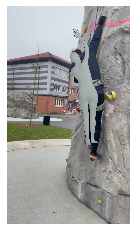

In [28]:
import mesh
reload(mesh)
reload(meva.utils.demo_utils)
verts = res['verts'][seqidx, frameid].copy()
cam = res['pred_cam'][seqidx, frameid].copy()
bboxes = seqinfo['bboxes'][frameid:].copy()
img = seqinfo['raw_imgs'][frameid].copy()
print(cam)
cam[0] *= 1.2
imshownp(mesh.render_pred_mesh(img, bboxes, verts, cam), bgr=True)

In [ ]:
in_folder = '/home/tormod/ucph-erda-home/climb_meva_results'
oks_testval = eval_res('testval')

In [ ]:
score_per_frame(oks_testval)

In [ ]:
score_per_joint_per_frame(oks_testval)

# Render Results

In [22]:
from meva.utils.renderer import Renderer
from meva.utils.demo_utils import convert_crop_cam_to_orig_img
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
def render_vids(cd, res, out_folder, vid_idx):
    vid = cd.vids[vid_idx]
    vid_name = data.stripped_names[vid_idx]
    cd.load_labels(vid_name)
    bboxes = cd.bboxes[vid_name]
    orig_width, orig_height = vid.resolution
    renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True)
    vertss = res['verts']
    vertss = vertss.reshape(-1, vertss.shape[-2], vertss.shape[-1])
    pred_cams = res['pred_cam']
    pred_cams = pred_cams.reshape(-1, pred_cams.shape[-1])
    for frame in trange(len(vertss)):
        img = vid[frame]
        verts = vertss[frame]
        pred_cam = pred_cams[np.newaxis, frame].copy()
        pred_cam[:, 0] *= 1.2
        bbox = bboxes[np.newaxis, frame]
        orig_cam = convert_crop_cam_to_orig_img(
            pred_cam, bbox, orig_width, orig_height)[0]
        mesh_img = renderer.render(img, verts, orig_cam)
        
        black_img = renderer.render(np.zeros_like(img), verts, orig_cam)  
        
        out_img = np.concatenate([black_img, mesh_img], axis=1)
        mmcv.imwrite(out_img, f'{out_folder}/{vid_name}/{frame:06d}.png')

    mmcv.frames2video(f'{out_folder}/{vid_name}', f'{out_folder}/{vid_name}.mp4',
                      filename_tmpl='{:06d}.png')

In [23]:
vid_folder = '/media/tormod/Den Lille/Thesis/videos'
cd = data.ClimbingDataset('all', video_folder=vid_folder)

## Pre-trained

In [24]:
in_folder = '/home/tormod/ucph-erda-home/pretrained_meva_results'
out_folder = '/media/tormod/Den Lille/Thesis/pretrained_meva_results'
vid_idx = 0
vid_name = data.stripped_names[vid_idx]
res = joblib.load(f'{in_folder}/{vid_name}.pkl')

In [26]:
render_vids(cd, res, out_folder, vid_idx)

KeyboardInterrupt: 

## Climb-trained

In [30]:
in_folder = '/home/tormod/ucph-erda-home/climb_meva_results'
out_folder = '/media/tormod/Den Lille/Thesis/climb_meva_results'
vid_idx = 0
vid_name = data.stripped_names[vid_idx]
res = joblib.load(f'{in_folder}/{vid_name}.pkl')

In [32]:
render_vids(cd, res, out_folder, vid_idx)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6750/6750, 27.9 task/s, elapsed: 242s, ETA:     0s


## MEVA30

In [33]:
in_folder = '/home/tormod/ucph-erda-home/vae30_meva_results'
out_folder = '/media/tormod/Den Lille/Thesis/vae30_meva_results'
vid_idx = 0
vid_name = data.stripped_names[vid_idx]
res = joblib.load(f'{in_folder}/{vid_name}.pkl')

In [34]:
render_vids(cd, res, out_folder, vid_idx)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6810/6810, 27.8 task/s, elapsed: 245s, ETA:     0s


# Eval Results

In [36]:
from meva.lib.smpl import SMPL, SMPL_MODEL_DIR
from meva.lib import meva_model
smpl = SMPL(SMPL_MODEL_DIR,
            batch_size=64,
            create_transl=False)
smpl_feet_and_hands = [11,10,23,22]
climb_feet_and_hands = [12,16,4,8]
def get_smpl_joints(verts, pred_cam):
    smpl_joints = vertices2joints(smpl.J_regressor, torch.Tensor(verts))
    joints2d = meva_model.projection(smpl_joints, torch.Tensor(pred_cam))
    return joints2d.numpy()
    
def get_extra_joints(r):
    v = r['verts'].copy()
    theta = r['theta'].copy()
    pc = theta[:, :3]
    smpl_joints2d = get_smpl_joints(v, pc)
    return smpl_joints2d[:, smpl_feet_and_hands, :]

In [37]:
def eval_res(split, seq_len=90):
    cd = data.ClimbingDataset(split, seq_len=seq_len, preload_all=True)
    current_vid_name = ''
    res = []
    scores = []
    for seqidx, seq_info in tqdm(enumerate(cd)):
        inv_trans = seq_info['inv_trans']
        vid_idx = seq_info['vid_idx']
        vid_name = data.stripped_names[vid_idx]
        if vid_name != current_vid_name:
            res = joblib.load(f'{in_folder}/{vid_name}.pkl')
            current_vid_name = vid_name
        scales = seq_info['bboxes'][:,-1]
        frames = seq_info['frames']
        pred_seq = res['joints2d'][seqidx].copy()
        gt_seq = seq_info['kp_2d'].numpy()
        oks_score = utils.oks(pred_seq, gt_seq, scales, inv_trans)
        scores.append(oks_score)
    scores = np.stack(scores)
    scores = scores.reshape(-1, scores.shape[-1])
    # delete values for eye joints
    scores = np.delete(scores, 1, 1)
    scores = np.delete(scores, 1, 1)
    return scores

def score_per_frame(oks_score):
    conv_N = 3*90
    smooth_oks_score = scipy.ndimage.convolve(oks_score, np.ones((conv_N, 1))/conv_N, mode='mirror')
    plt.plot(smooth_oks_score.mean(axis=1))
    plt.ylim((0,1))
    
def score_per_joint_per_frame(oks_score):
    colors = cm.tab20(np.linspace(0,1,19))
    coco_joint_names = kp_utils.get_coco_joint_names()
    coco_joint_names = coco_joint_names[:1] + coco_joint_names[3:]
    climb_names = np.array(data.get_climb_joint_names())[climb_feet_and_hands]
    coco_joint_names = coco_joint_names + list(climb_names)
    conv_N = 3*90
    for j in range(oks_score.shape[1]):
        j_oks = oks_score[:,j].copy()
        j_oks = scipy.ndimage.convolve(j_oks, np.ones(conv_N)/conv_N, mode='mirror')
        plt.plot(j_oks, label=coco_joint_names[j], color=colors[j])
    plt.legend(loc='lower left', ncol=2)
    plt.ylim((0,1))

## Pretrained

In [38]:
in_folder = '/home/tormod/ucph-erda-home/pretrained_meva_results'
oks_testval = eval_res('testval')
#oks_test = eval_res('test')
#oks_val = eval_res('val')
#oks_train = eval_res('train')

In [40]:
oks_testval.mean(axis=0)

array([0.53986082, 0.68641697, 0.69349729, 0.91464597, 0.91351721,
       0.89086952, 0.89296956, 0.84403022, 0.85422573, 0.9733444 ,
       0.9748282 , 0.93073258, 0.93576903, 0.92260825, 0.92189886])

In [ ]:
oks_testval, oks_test, oks_val, oks_train

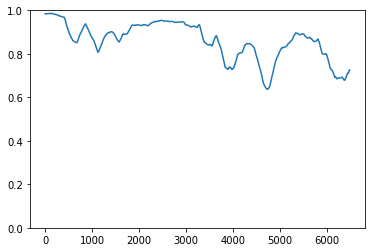

In [29]:
score_per_frame(oks_testval)

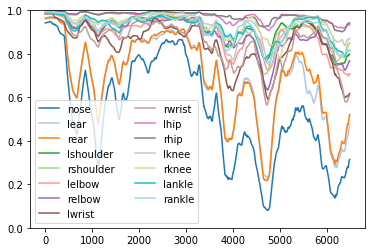

In [30]:
score_per_joint_per_frame(oks_testval)

## Climb-trained

In [31]:
in_folder = '/home/tormod/ucph-erda-home/climb_meva_results'
oks_testval = eval_res('testval')

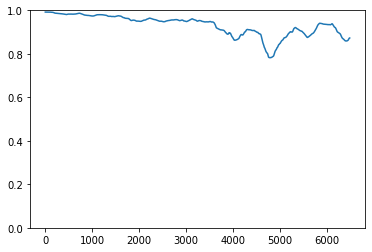

In [32]:
score_per_frame(oks_testval)

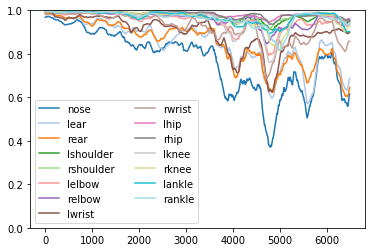

In [33]:
score_per_joint_per_frame(oks_testval)

## MEVA30

In [36]:
in_folder = '/home/tormod/ucph-erda-home/vae30_meva_results'
oks_testval = eval_res('testval', seq_len=30)

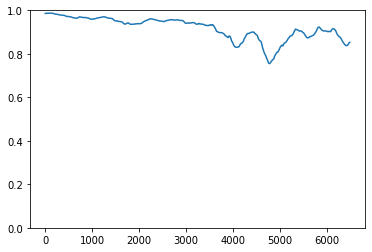

In [37]:
score_per_frame(oks_testval)

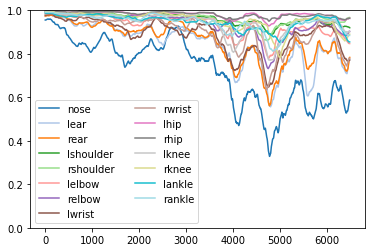

In [38]:
score_per_joint_per_frame(oks_testval)

# Loss graphs

In [83]:
import re
import matplotlib.pyplot as plt
import numpy as np
def get_meva_losses(in_file):
    val_kpl, train_kpl, okss = [], [], []
    for l in open(in_file):
        m1 = re.search(r'Epoch (.+), KP_LOSS: (.+), OKS_SCORE: (.+),', l)
        m2 = re.search(r'loss_kp_2d: (\S+)', l)
        if m1:
            epoch, kp, oks = m1.groups()
            val_kpl.append(float(kp))
            okss.append(float(oks))    
        if m2:
            kp, = m2.groups()
            train_kpl.append(float(kp))
    val_kpl, train_kpl, okss = np.array(val_kpl), np.array(train_kpl), np.array(okss)
    return val_kpl, train_kpl, okss

In [116]:
in_file = '/home/tormod/cluster/APEC/results/meva/train_meva_climb/train_log.txt'
val_kpl, train_kpl, okss, = get_meva_losses(in_file)

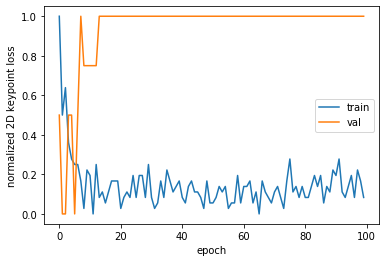

In [117]:
plt.plot((train_kpl-train_kpl.min())/(train_kpl-train_kpl.min()).max())
plt.plot((val_kpl-val_kpl.min())/(val_kpl-val_kpl.min()).max())
plt.legend(('train', 'val'))
plt.ylabel('normalized 2D keypoint loss')
plt.xlabel('epoch')
plt.savefig('climb-loss.png', bbox_inches='tight', dpi=100)

In [118]:
in_file = '/home/tormod/cluster/APEC/results/meva/train_meva_all_vae30/train_log.txt'
val_kpl, train_kpl, okss, = get_meva_losses(in_file)

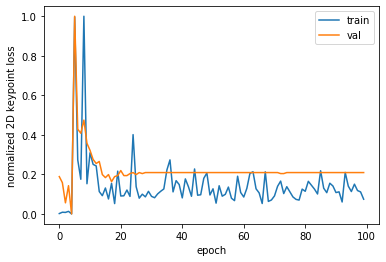

In [119]:
plt.plot((train_kpl-train_kpl.min())/(train_kpl-train_kpl.min()).max())
plt.plot((val_kpl-val_kpl.min())/(val_kpl-val_kpl.min()).max())
plt.legend(('train', 'val'))
plt.ylabel('normalized 2D keypoint loss')
plt.xlabel('epoch')
plt.savefig('meva30-loss.png', bbox_inches='tight', dpi=100)

In [120]:
def vae_losses(in_file):
    mses, mse_rts, klds = [], [], []
    for l in open(in_file):
        m1 = re.search(r'MSE: (\S+) MSE_RT: (\S+) KLD: (\S+)', l)
        if m1:
            mse, mse_rt, kld = m1.groups()
            mses.append(float(mse))
            mse_rts.append(float(mse_rt))
            klds.append(float(kld))
    mses, mse_rts, klds = np.array(mses), np.array(mse_rts), np.array(klds)
    return mses, mse_rts, klds

In [121]:
in_file = '/home/tormod/cluster/APEC/results/meva/apec_vae_rec_1/log/log.txt'
mse, mse_rt, kld = vae_losses(in_file)

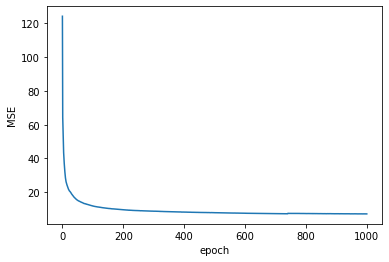

In [127]:
plt.plot(mse)
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.savefig('vae30-mse.png', bbox_inches='tight', dpi=100)

In [125]:
kld.argmin()

15

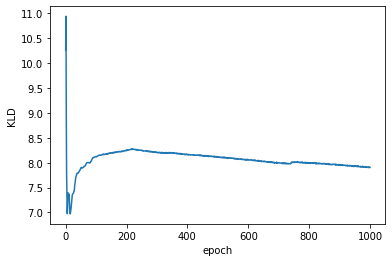

In [124]:
plt.plot(kld)
plt.ylabel('KLD')
plt.xlabel('epoch')
plt.savefig('vae30-kld.png', bbox_inches='tight', dpi=100)